**We are going to build a Bidirectional LSTM Neural Network to make the prediction on multivariate(many features) Time Series data.** 

**some of the steps we are going to take**
* Understanding of data
* Feature Engineering
* Data Exploration
* preprocessing
* Predicting Demand
* Evaluation

In [153]:
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

In [117]:

df = pd.read_csv(r"E:\github material\londan_bike\london_merged.csv",parse_dates=['timestamp'])

In [118]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


# 1. lets take a look to our features

* timestamp - timestamp field for grouping the data
* cnt - the count of a new bike shares
* t1 - real temperature in C
* t2 - temperature in C "feel like"
* hum - humidity in percentage
* wind_speed - wind speed in km/h
* weather_code - category of the weather
* is_holiday - boolean field - 1 holiday / 0 non holiday
* is_weekend - boolean field - 1 if the day is weekend
* season - category fiels meteorological seaon: 0-spring; 1-summer;
    2-fall; 3-winter

In [119]:
# set timestamp as index column
df.set_index("timestamp" ,inplace=True)
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


In [120]:
df.shape

(17414, 9)

# 2. Feature Engineering

Break the time stamp saprately in 'hour','day_of_month','day_of_week','month'

In [121]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1


# 3. Data Exploration

In [122]:
#look at the bikes share over time 

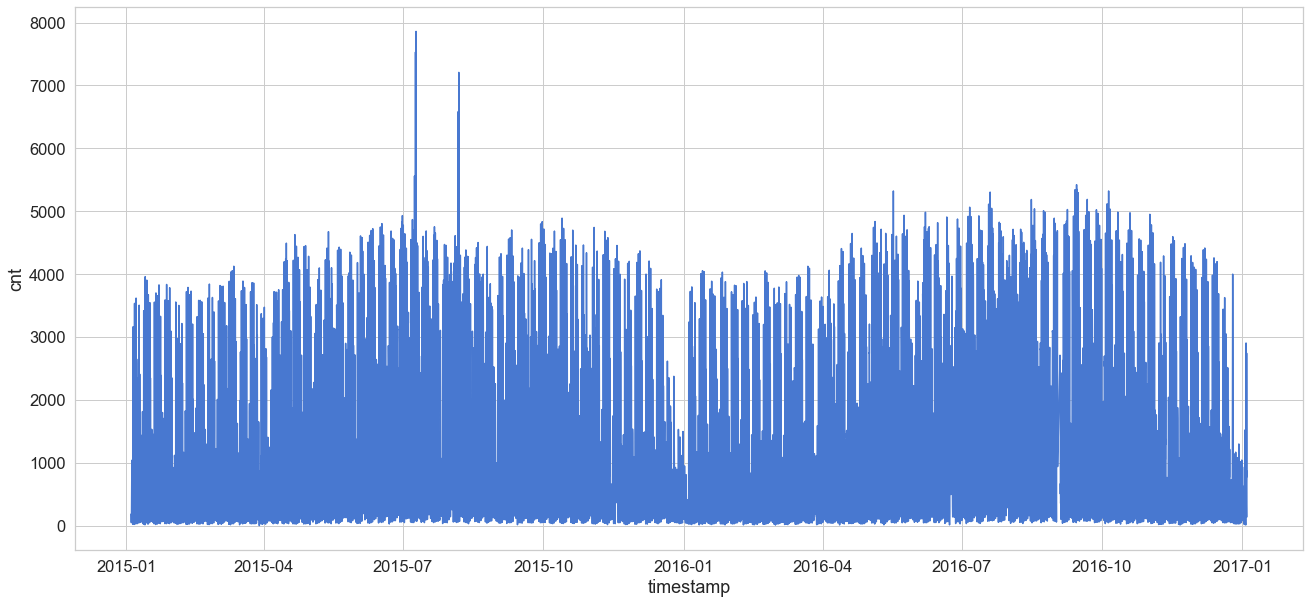

In [123]:

sns.lineplot(x=df.index, y='cnt', data=df)

In [124]:
df_by_month = df.resample('M').sum() # sample data with monthly basis:

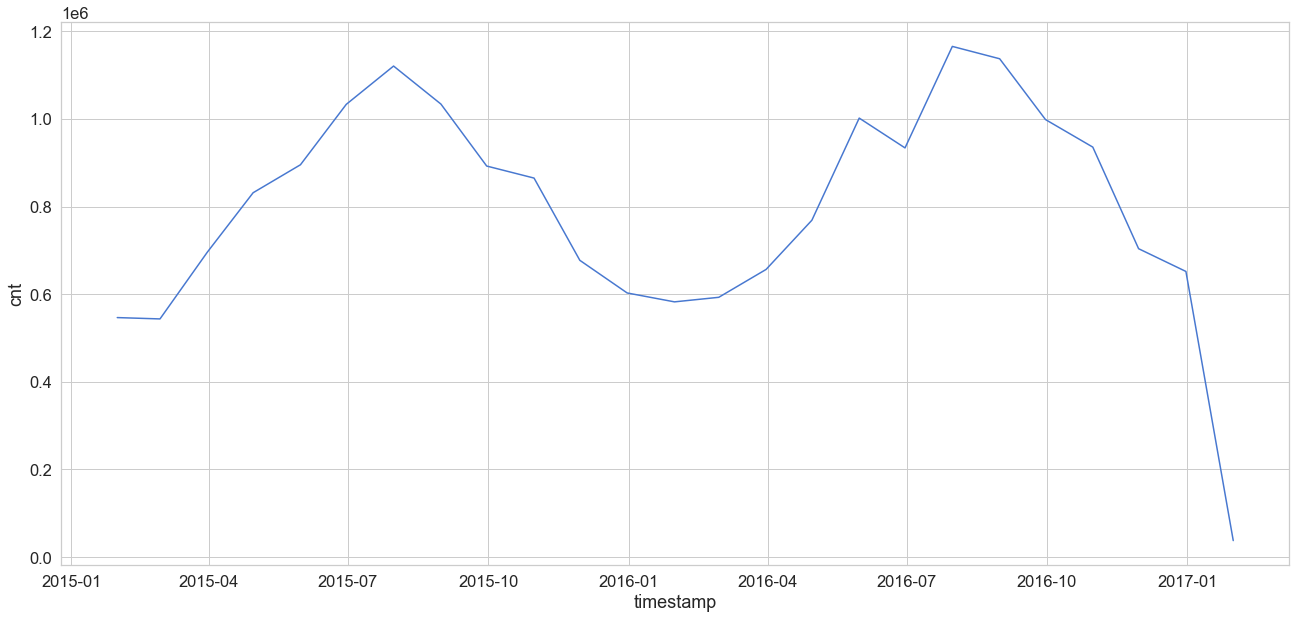

In [125]:
# bikes share over time(monthly basis)
sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month)

**ovservation is that bikes share strongly depends on season and demand is high in summer()summer is good for business.**

In [126]:
#bikes shares by the hour.

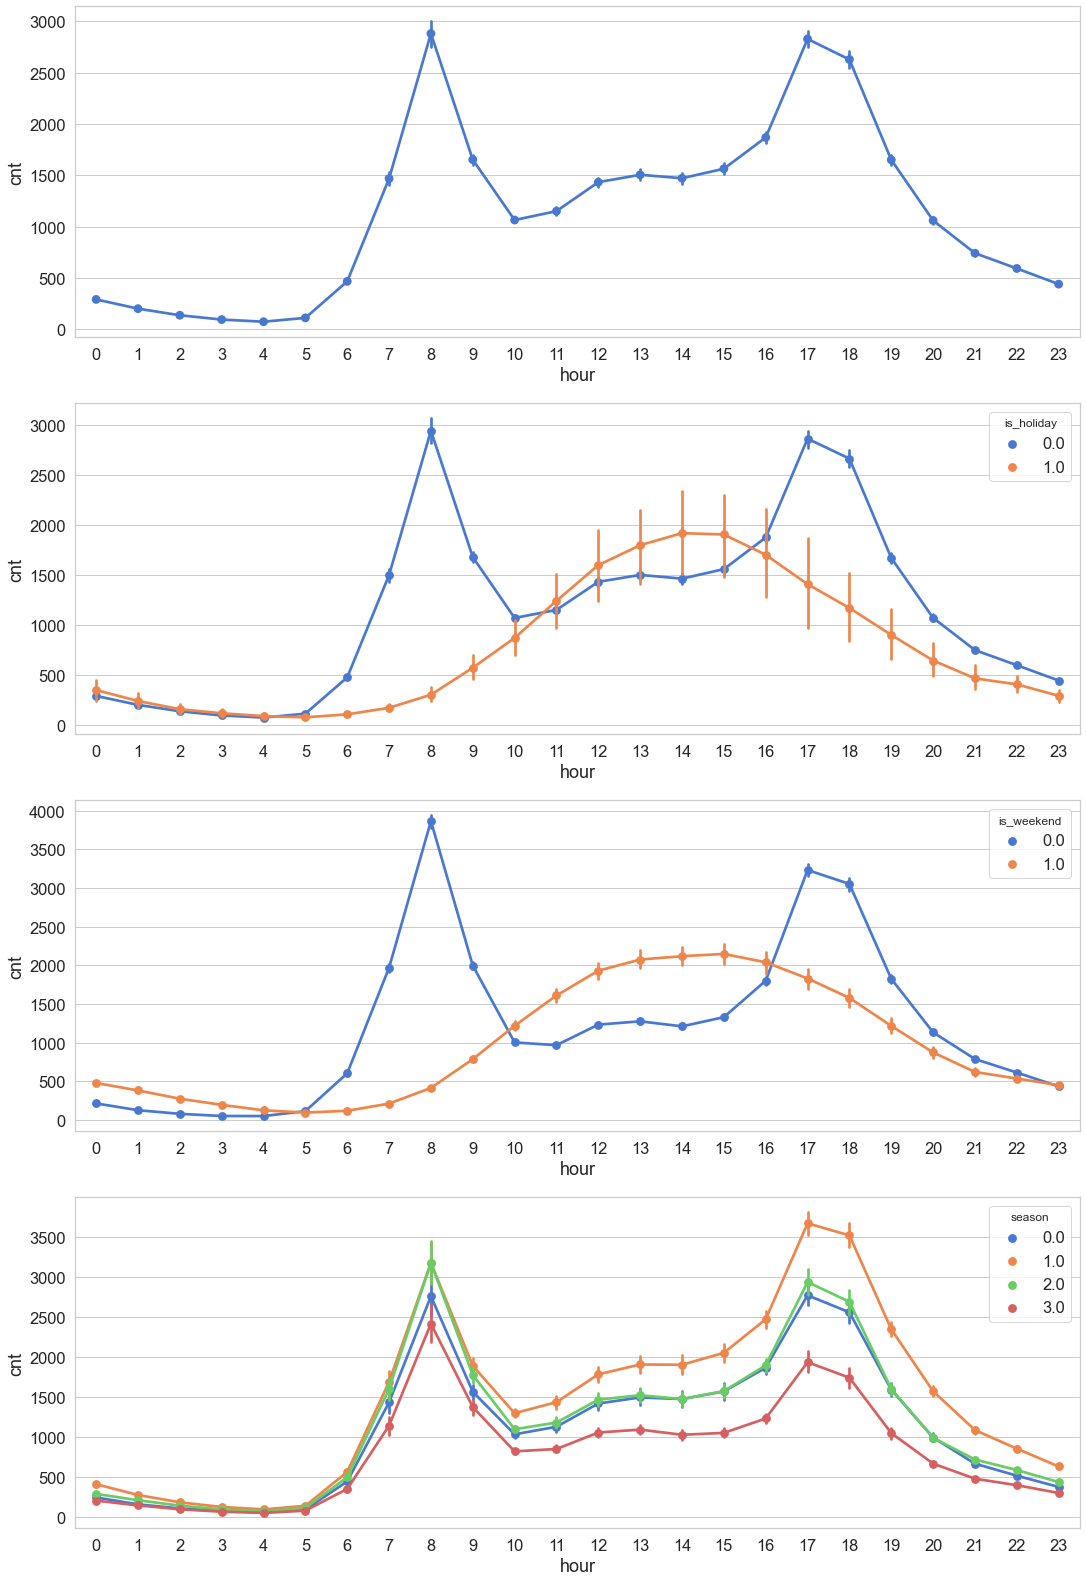

In [127]:
fig,(ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(18,28)
sns.pointplot(data=df, x='hour',y='cnt',ax=ax1)
sns.pointplot(data=df, x='hour',y='cnt',hue='is_holiday',ax=ax2)
sns.pointplot(data=df, x='hour',y='cnt',hue='is_weekend',ax=ax3)
sns.pointplot(data=df ,x='hour',y='cnt',hue='season',ax=ax4)

* Bike shares spikes at morning and late afternoons hours
* on weekend business is down 

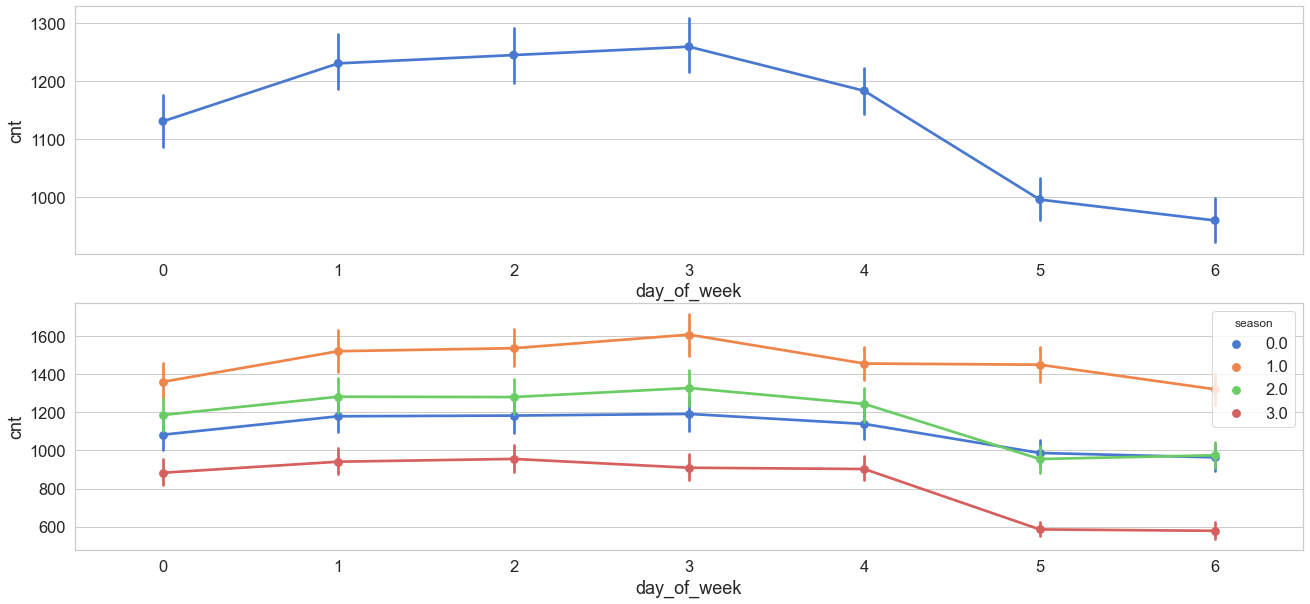

In [128]:
fig,(ax1,ax2) = plt.subplots(nrows=2)
sns.pointplot(x='day_of_week', y ='cnt',data=df, ax=ax1)
sns.pointplot(x='day_of_week', y='cnt',data=df,hue='season',ax=ax2)

*on week days business is better than weekend 

# 4. Preprocessing

In [136]:
train_size = int(len(df)*0.9)

In [137]:
test_size = len(df) - train_size

In [138]:
train =df.iloc[0:train_size]
test  =df.iloc[train_size:len(df)]
print(len(train) ,len(test))

15672 1742


We'll scale some of the features we're using for our modeling

In [140]:
from sklearn.preprocessing import RobustScaler
f_columns = ['t1','t2', 'hum','wind_speed']
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

In [145]:
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

C:\Users\user\Anaconda3.88\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-145-7225b59caad2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
C:\Users\user\Anaconda3.88\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [150]:
def creat_dataset(X ,y, time_steps=1):
    Xs ,ys = [] ,[]
    for i in range(len(X) - time_steps):
        v= X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [154]:
time_steps = 10  
# reshape to [samples, time_steps, n_features]
X_train, y_train =creat_dataset(train, train.cnt ,time_steps)
X_test ,y_test =creat_dataset(test ,test.cnt ,time_steps)
print(X_train.shape ,y_train.shape)

(15662, 10, 13) (15662,)


In [155]:
train.shape

(15672, 13)

# 5. Predictiong Demand 

In [174]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128
            )))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer ='adam')

In [178]:
history = model.fit(X_train , y_train,epochs =30,
          validation_split =0.1,
         shuffle=False
)

Epoch 1/30
441/441 [==============================] - 6s 14ms/step - loss: 0.0141 - val_loss: 0.0343
Epoch 2/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0136 - val_loss: 0.0303
Epoch 3/30
441/441 [==============================] - 6s 14ms/step - loss: 0.0136 - val_loss: 0.0245
Epoch 4/30
441/441 [==============================] - 7s 15ms/step - loss: 0.0137 - val_loss: 0.0250
Epoch 5/30
441/441 [==============================] - 7s 16ms/step - loss: 0.0135 - val_loss: 0.0261
Epoch 6/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0132 - val_loss: 0.0328
Epoch 7/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0135 - val_loss: 0.0365
Epoch 8/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0127 - val_loss: 0.0351
Epoch 9/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0128 - val_loss: 0.0329
Epoch 10/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0130 - val_lo

In [176]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 256)               145408    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
_________________________________________________________________


# 6. Evaluation

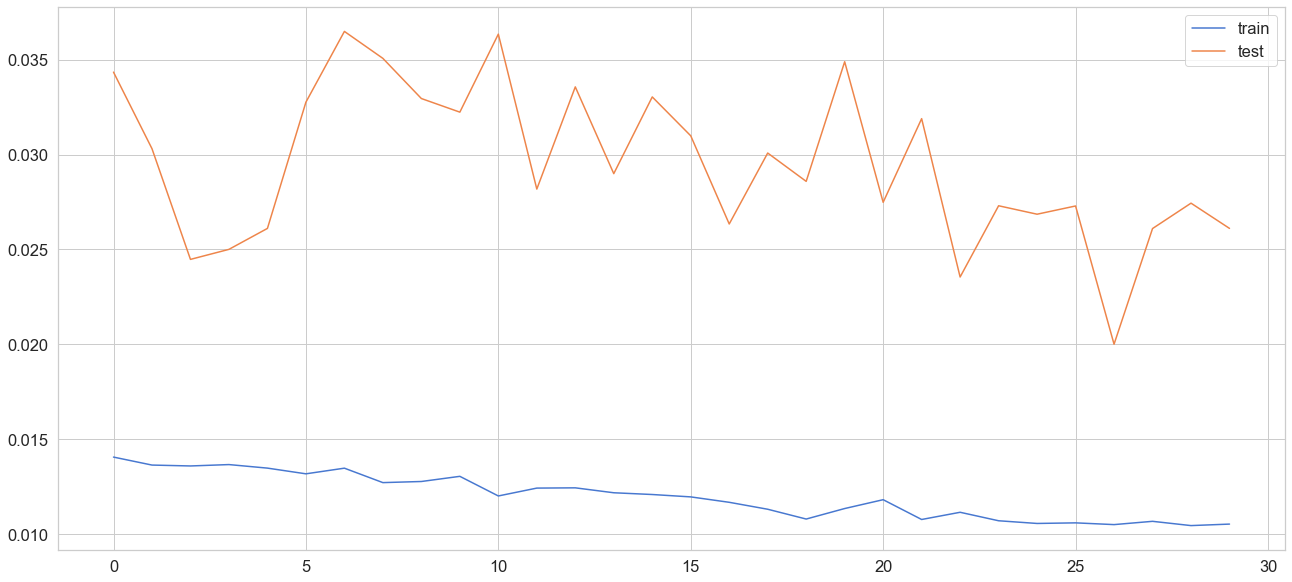

In [179]:
plt.plot(history.history['loss'] ,label ="train")
plt.plot(history.history['val_loss'],label='test')
plt.legend();

In [180]:
y_pred = model.predict(X_test)

In [183]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

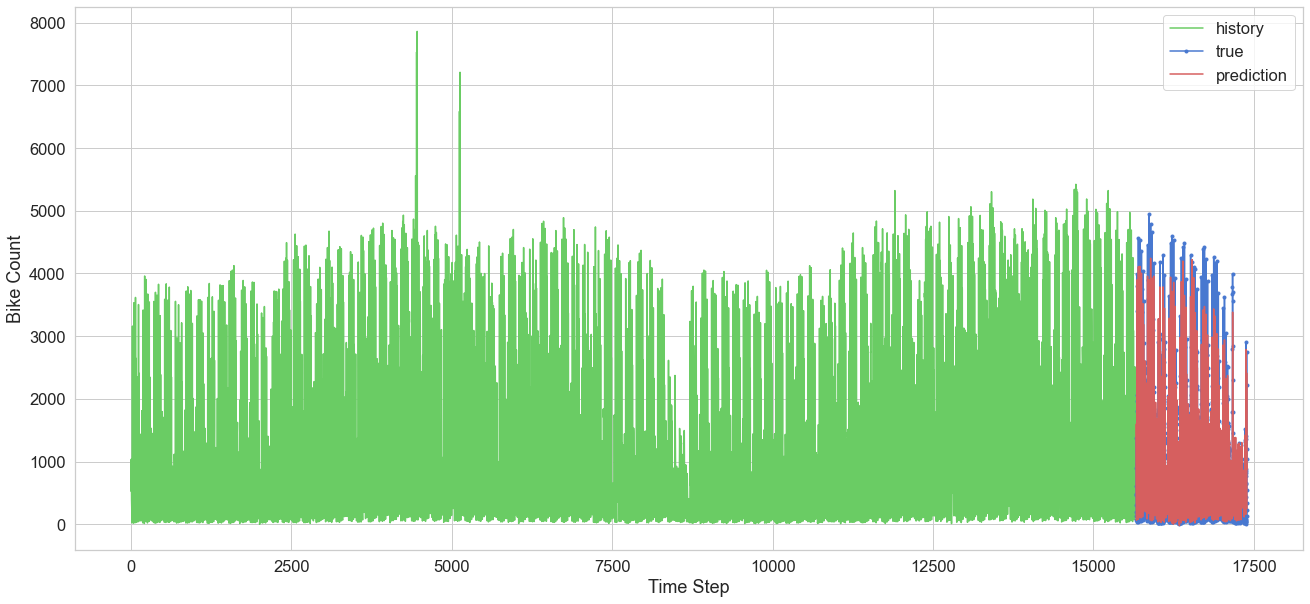

In [185]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

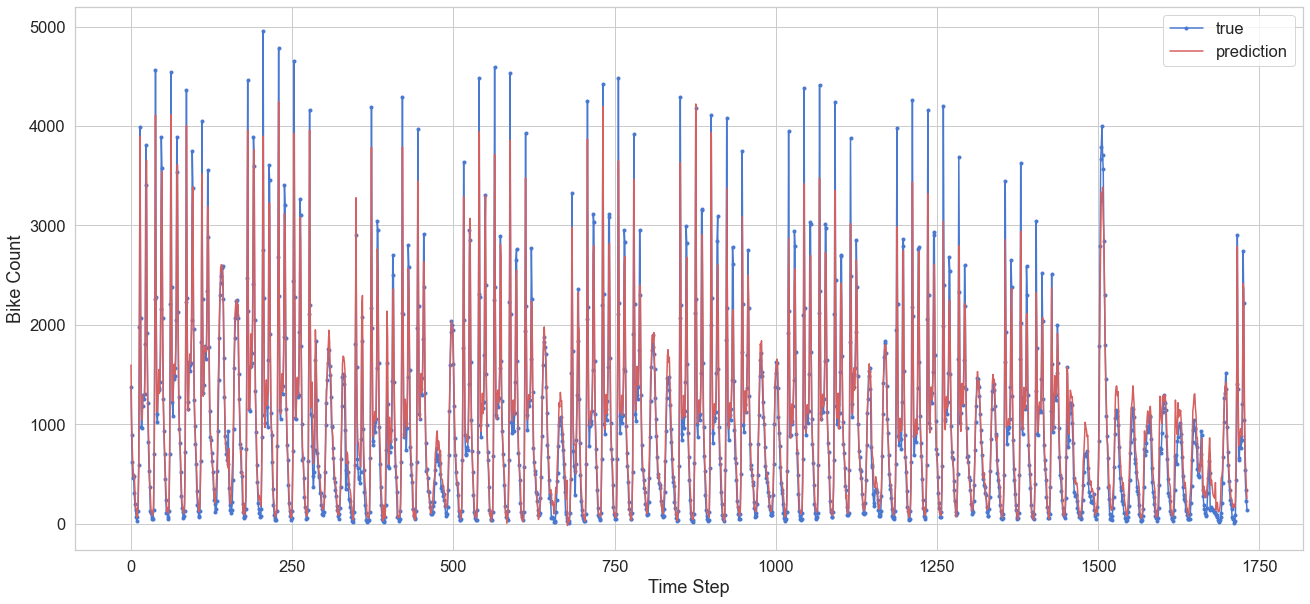

In [186]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Conclusion

we took a real dataset, preprocessed it, and used it to predict bike-sharing demand.
we used a bidirectional LSTM model to train it on subsequences from the original dataset. and got some very good results.

# References

* TensorFlow - Time series forecasting (https://www.tensorflow.org/tutorials/structured_data/time_series)
* Understanding LSTM Networks(https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* Londan bike sharing dataset (https://www.kaggle.com/hmavrodiev/london-bike-sharing-datase)